In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

In [2]:
import os

In [3]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c = 0.262, Omega_b = 0.048, h = 0.69, sigma8 = 0.83, n_s = 0.96)

zs=np.linspace(0,1,100)
dNdz = np.ones(zs.shape)
bias = 1*np.ones(len(dNdz))

clustering = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zs,dNdz), bias=(zs,bias))
ell = np.arange(0,6144)
cls_clu = ccl.angular_cl(cosmo, clustering, clustering, ell) #Clustering

In [4]:
kSZMap = hp.read_map("./kSZ_NS_2048_R_2048_P_2560_DV_256.fits")

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [5]:
kSZPowSpec = hp.anafast(kSZMap)

In [6]:
kSZFiles = os.listdir('./Data/kSZ')
velFiles = os.listdir('./Data/velocityField')
densFiles = os.listdir('./Data/overdensity')

nside = 64
numSets=len(densFiles)

In [7]:
overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

In [8]:
for i in range(0,numSets):
    overdensData[i] = hp.reorder(np.load('./Data/overdensity/'+densFiles[i]),r2n=True)
    kSZData[i] = hp.reorder(np.load('./Data/kSZ/'+kSZFiles[i]),r2n=True)
    velData[i] = hp.reorder(np.load('./Data/velocityField/'+velFiles[i]),r2n=True)
# for i in range(0,numSets):
#     overdensData[i] = hp.reorder(hp.synfast(cls_clu,nside=nside),r2n=True)
#     kSZData[i] = hp.reorder(100000*hp.synfast(kSZPowSpec,nside=nside),r2n=True)
#     velData[i] = hp.reorder(kSZData[i]/(overdensData[i]+1),r2n=True)

In [9]:
x_raw = np.stack((overdensData,kSZData,kSZData/overdensData),axis=2)
x_raw = np.reshape(x_raw,(numSets,12*nside**2,3))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-85])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-85])

In [177]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.shuffle(50)
dset_test = dset_test.batch(10)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))
dset_train = dset_train.shuffle(200)
dset_train = dset_train.batch(10)

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

dset_train = dset_train.prefetch(buffer_size=AUTOTUNE)
dset_test = dset_test.prefetch(buffer_size=AUTOTUNE)

In [11]:
#hp.mollview(overdensData[350],nest=True)

In [12]:
#hp.mollview(velData[350],nest=True)

In [13]:
#hp.mollview(kSZData[350],nest=True)

In [18]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [147]:
K = 10
layers = [hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=8, activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=32, activation="linear"),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.Dense(12*nside**2)
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=1, use_bias=True, use_bn=False, 
                                   activation="linear")
         ]

In [148]:
#help(hp_layer.HealpyMonomial)

In [149]:
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
modelHP = HealpyGCNN(nside=nside, layers=layers,indices=np.arange(0,12*nside**2), n_neighbors=40)
modelHP.build(input_shape=(None, len(indices), 3))
modelHP.summary(110)

Detected a reduction factor of 1.0, the input with nside 64 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_31"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 chebyshev_147 (Chebyshev)                       (None, 49152, 8)                            248              
                                                                                                              
 healpy_pseudo_conv_37 (HealpyPseudoConv)        (None, 12288, 8)                            264              
                                                                                                              
 chebyshev_148 (Chebyshev)                       (None, 12288, 16)                           1296             
                      

In [150]:
modelHP.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              #loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
                loss="MAE",
              metrics=[r_square]
)

In [160]:
history = modelHP.fit(
    dset_train,
    epochs=50,
    validation_data = dset_test
)

Epoch 1/50
140/140 [==============================] - 97s 691ms/step - loss: 1689.5756 - r_square: -0.0181 - val_loss: 1719.9154 - val_r_square: -0.0205
Epoch 2/50
140/140 [==============================] - 97s 692ms/step - loss: 1686.6064 - r_square: -0.0095 - val_loss: 1722.8402 - val_r_square: -0.0174
Epoch 3/50
140/140 [==============================] - 97s 692ms/step - loss: 1684.5800 - r_square: -0.0145 - val_loss: 1719.4462 - val_r_square: -0.0335
Epoch 4/50
140/140 [==============================] - 97s 692ms/step - loss: 1680.4150 - r_square: -0.0063 - val_loss: 1717.2606 - val_r_square: -0.0308
Epoch 5/50
140/140 [==============================] - 97s 692ms/step - loss: 1674.6973 - r_square: 0.0021 - val_loss: 1732.2263 - val_r_square: -0.0303
Epoch 6/50
140/140 [==============================] - 97s 692ms/step - loss: 1659.9205 - r_square: 0.0142 - val_loss: 1732.7057 - val_r_square: -0.0304
Epoch 7/50
140/140 [==============================] - 97s 692ms/step - loss: 1631.69

In [174]:
modelHP.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              #loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
                loss=tf.keras.losses.MeanSquaredError(),
              metrics=[r_square]
)

In [176]:
initial_epochs = 50
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_further = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=dset_test)

Epoch 50/60
140/140 [==============================] - 103s 694ms/step - loss: 2623010.2500 - r_square: 0.3987 - val_loss: 7197200.0000 - val_r_square: -0.5664
Epoch 51/60
140/140 [==============================] - 97s 693ms/step - loss: 2553223.5000 - r_square: 0.4146 - val_loss: 9099526.0000 - val_r_square: -0.9868
Epoch 52/60
140/140 [==============================] - 97s 693ms/step - loss: 2524515.0000 - r_square: 0.4197 - val_loss: 7787194.0000 - val_r_square: -0.7349
Epoch 53/60
140/140 [==============================] - 97s 693ms/step - loss: 2508796.2500 - r_square: 0.4282 - val_loss: 8197186.5000 - val_r_square: -0.7538
Epoch 54/60
140/140 [==============================] - 97s 693ms/step - loss: 2487978.2500 - r_square: 0.4309 - val_loss: 7786216.0000 - val_r_square: -0.6507
Epoch 55/60
140/140 [==============================] - 97s 694ms/step - loss: 2488983.5000 - r_square: 0.4332 - val_loss: 9057342.0000 - val_r_square: -0.9589
Epoch 56/60
140/140 [========================

In [178]:
total_epochs =  initial_epochs + fine_tune_epochs+10

history_furthest = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history_further.epoch[-1],
                         validation_data=dset_test)

Epoch 60/70
140/140 [==============================] - 97s 693ms/step - loss: 2451686.7500 - r_square: 0.4388 - val_loss: 8490855.0000 - val_r_square: -0.8727
Epoch 61/70
140/140 [==============================] - 97s 694ms/step - loss: 2447102.0000 - r_square: 0.4421 - val_loss: 8749057.0000 - val_r_square: -0.8926
Epoch 62/70
140/140 [==============================] - 97s 694ms/step - loss: 2439062.2500 - r_square: 0.4419 - val_loss: 9090309.0000 - val_r_square: -1.0177
Epoch 63/70
140/140 [==============================] - 97s 694ms/step - loss: 2437263.5000 - r_square: 0.4435 - val_loss: 7627420.0000 - val_r_square: -0.6270
Epoch 64/70
140/140 [==============================] - 97s 694ms/step - loss: 2444583.7500 - r_square: 0.4414 - val_loss: 8303294.5000 - val_r_square: -0.8291
Epoch 65/70
140/140 [==============================] - 97s 694ms/step - loss: 2432150.7500 - r_square: 0.4439 - val_loss: 7630307.5000 - val_r_square: -0.6595
Epoch 66/70
140/140 [=========================

In [179]:
reconst = np.reshape(modelHP(x_train[:1],True).numpy(),(12*nside**2))
goal = np.reshape(y_train[:1],(12*nside**2))

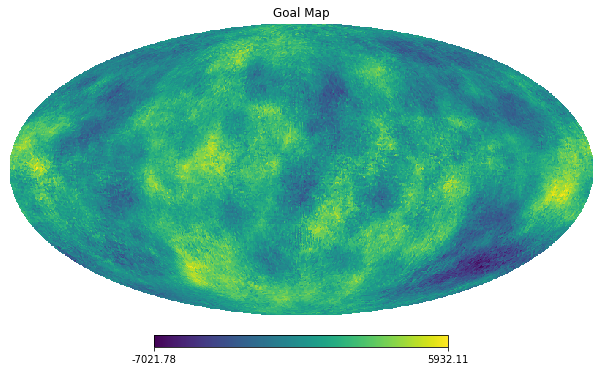

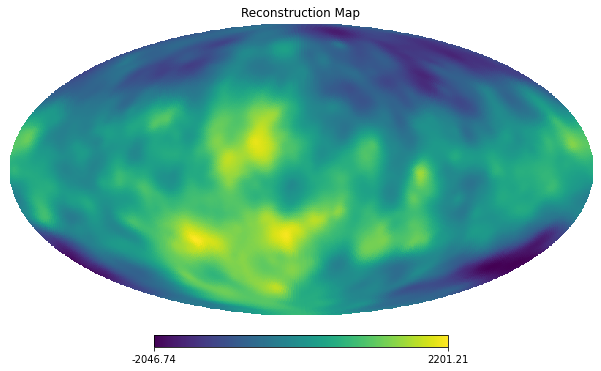

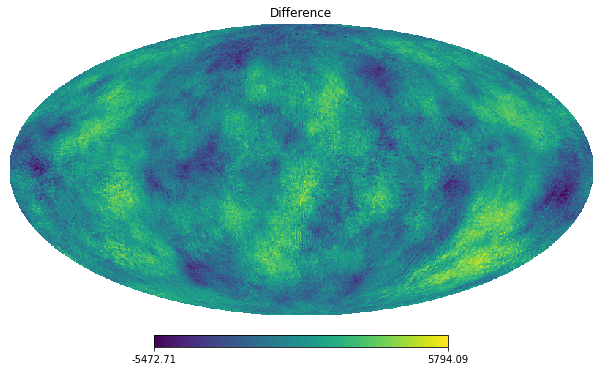

In [180]:
hp.mollview(goal, nest=True, title="Goal Map");
hp.mollview(reconst, nest=True, title="Reconstruction Map");
hp.mollview(reconst - goal, nest=True, title="Difference");

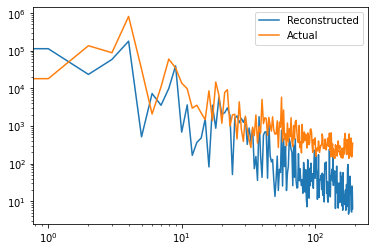

In [181]:
plt.loglog(hp.anafast(reconst))
plt.loglog(hp.anafast(goal))
plt.legend(["Reconstructed","Actual"])

In [182]:
correlation = hp.anafast(reconst,goal)/np.sqrt(hp.anafast(goal)*hp.anafast(reconst)) 

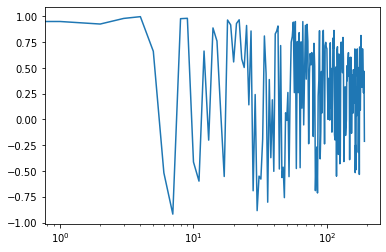

In [183]:
plt.semilogx(correlation);

In [184]:
np.mean(correlation)

0.29181822996250045

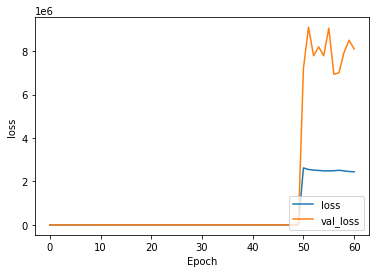

In [189]:
plt.plot(np.append(history.history['loss'],history_further.history['loss']), label='loss')
plt.plot(np.append(history.history['val_loss'],history_further.history['val_loss']), label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

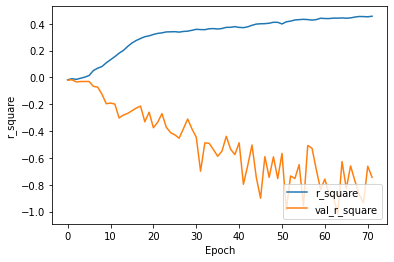

In [191]:
plt.plot(np.append(np.append(history.history['r_square'],history_further.history['r_square']),history_furthest.history['r_square']), label='r_square')
plt.plot(np.append(np.append(history.history['val_r_square'],history_further.history['val_r_square']),history_furthest.history['val_r_square']), label = 'val_r_square')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('r_square')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')